<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/split-and-simple-perturb/sequences/P2C1_Optimization/P2C1_Sequence3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is part of a test for an upcoming text book on computational neuroscience from an optimization and learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as an optimization algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

___
# **2.1.3: Optimization in Higher Dimensions: The Need for Speed**

### Objective: See how and why the optimization methods propose-accept-reject and perturb-measure-step become intractably slow for higher dimensional problems, i.e. they do not scale well. See that high-dimensional problems are ubiquitous in neural systems.

In this sequence we will:

* Analytically optimize a function of many variables, using ideas and tools from calculus, generalizing our approach for two dimensions to $n$ dimensions.

* Discover how and why propose-accept-reject and pertrub-measure-step slow down in higher dimensional problems using both simulations with a simple high dimensional function and a general mathematical analysis.

* Examine what Stochastic-Perturb-Measure-Step is doing at the single parameter level and connect this to simple linear regression


# Setup

Run the following cell to setup and install the various dependencies and helper functions for this .

In [1]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**
!apt install libgraphviz-dev > /dev/null 2> /dev/null #colab
!pip install ipympl pygraphviz vibecheck datatops jupyterquiz ucimlrepo > /dev/null 2> /dev/null #google.colab

import asyncio
import requests
from requests.exceptions import RequestException
import numpy as np
import itertools
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
from matplotlib.animation import FuncAnimation
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
import pygraphviz as pgv
import ipywidgets as widgets
import time
import logging
import random
import os
import copy
import torch
import warnings
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from io import BytesIO
from enum import Enum
from scipy.spatial.distance import cdist
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown, HTML, Image
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm
from ucimlrepo import fetch_ucirepo

data_set = fetch_ucirepo(id=80)
X = data_set.data.features.values
# Translate the data to have a minimum of 0
X_translated = X - X.min()
# Scale the data to have a range from 0 to 12 (which is 6 - (-6))
scaling_factor = 12 / (X.max() - X.min())
X_scaled = X_translated * scaling_factor
# Finally, shift the data to be centered between -6 and 6
X_final = X_scaled - 6

y = data_set.data.targets.values
rng = np.random.default_rng(seed=2021)
scramble_permutation = rng.permutation(X.shape[1])
Xs = X_final[:, scramble_permutation]
y1 = y % 2
y2 = np.array(y >= 5, dtype=y.dtype)
simple_index = ((y.flatten()==1) | (y.flatten()==0))
X_simple = Xs[simple_index]
y1_simple = y1[simple_index]
# if you only had one feature which would likely be best for discrimination
epsilon = 10
class_a_sep = np.mean(X_simple[y1_simple.flatten() == 1, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 1, :], axis=0) + epsilon)
class_b_sep = np.mean(X_simple[y1_simple.flatten() == 0, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 0, :], axis=0) + epsilon)
best_feature = np.argmax(class_a_sep - class_b_sep)
print(f'Best feature is {best_feature}')
X_simple_1_feature = X_simple[:, [best_feature]]

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("This notebook isn't using and doesn't need a GPU. Good.")
  else:
    print("GPU is enabled in this notebook but not needed.")
    print("If possible, in the menu under `Runtime` -> ")
    print("`Change runtime type.`  select `CPU`")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import data_table
  data_table.disable_dataframe_formatter()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P2C1_S2"

Best feature is 21
Random seed 2021 has been set.
This notebook isn't using and doesn't need a GPU. Good.
Running in colab


# 2.1.3.1: Optimizing a Quadratic of Many Variables Analytically

Last sequence we looked at optimization problems in 2 dimensions. We solved these analytically, and also with perturb-measure-step and propose-accept-reject. Both worked okay. Now we're going to study how long it takes for these two different learning algorithms to find optimal values as the dimension becomes higher and higher. We let $n$ denote the number of dimensions, and ask the question which value of $\mathbf{x} \in \mathbb{R}^n$ (the real valued vector in an $n$ dimensional Euclidean space), minimizes(or maximizes) the function $f(\mathbf{x})$.

For the sake of keeping our analyses as simple as possible we work with the function

$$f(\mathbf{x}) = \sum_{i=1}^{N}x_i^2 $$

where $x_i$ denotes the $i^{th}$ element of $\mathbf{x}$. This function's simplicity and lack of local minima make it useful for clearly illustrating fundamental scaling challenges"

Maybe it's obvious to you that this particular function has exactly one minimum at $\mathbf{x} = \mathbf{0}$. If not we can take the partial derivatives

$$\frac{\partial f}{\partial x_i} = 2x_i \quad \text{for } i \in \{1, \dots, n\}$$

Setting these $n$ equations equal to zero gives us that the critical point is $\mathbf{x} = \mathbf{0}$.

We also need to check the concavity (whether the curve bends upwards or downwards or some mix of the two) to see if this zero-derivative point is a maximum or a minimum (or some other kind of inflection point, we are looking for a minimum in this case). In the same way that the first partial derivatives give the slope of $f(x,y)$ in the direction of the two parameters, i.e. the slope of the tangent plane, the second derivative gives the curvature.

So we need to look at the Hessian matrix.

$$\frac{\partial^2 f}{\partial x_i^2} = 2 \quad \text{for } i \in \{1, \dots, n\}$$
$$\frac{\partial^2 f}{\partial x_i \partial x_j} = 0 \quad \text{for } i, j \in \{1, \dots, n\}, \quad i \neq j$$

So,
$$H(f) = 2 \cdot \mathbf{I}$$
Where $\mathbf{I}$ is the identity matrix (ones on the diagonal zeros everywhere else) in $n$ dimensions. The generalization of the determinant rule in two dimensions, is that the function has a maximum or minimum if and only if all of the eigenvalues of the Hessian are positive. In general the eigenvalues of large matrices require some effort to compute, but for diagonal matrices the eigenvalues are just the entries on the diagonal. So in this case every eigenvalue is positive. In math jargon the Hessian is *positive definite*. Also the second derivatives are all positive and so we know that $\mathbf{x} = \mathbf{0}$ is a minimum.

We're not even going to try to draw you a picture of this high dimensional object.


In [2]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M1")

# 2.1.3.2: Optimizing a Quadratic of Many Variables with Propose-Accept-Reject and Perturb-Measure-Step

In the previous sequences we built up our intuitions around the Propose-Accept-Reject algorithm in lower dimensions. Now we're going to try to develop our intuitions around how the number of dimensions, or scale, of the problem affects the rate at which Propose-Accept-Reject can get close to an optimal solution. Systematic comparisons of learning algorithms is notorously fraught, as different meta-parameter setting, such as step size, can drastically influence outcomes. Good meta-parameters settings for one particular combination of alogorithm and problem, will be very different from those of another combination of algorithm and problem. All the details can and sometimes do matter. That said we can still develop some useful intuitions about scale, by studying a very simple system.

We will keep using the simple quadratic function

$$f(\mathbf{x}) = \sum_{i=1}^{N}x_i^2 $$

and see how the rate of convergence to a good solution changes as we increase the number of dimensions. In the simulations below the algorithms run until either 2000 iterations have been completed, or the value of $f(\mathbf{x})$ is less 0.1. For ease of comparison we will initialize $\mathbf{x}$ randomly, such that $\| \mathbf{x} \| = 5$. We will first look at propose-accept-reject, where the proposals average distance from the current point, i.e. the average step size is set at $s=0.1$. This setup allows us to focus on the effects of dimensionality on convergence behavior. Run the cell below to see what this looks like.

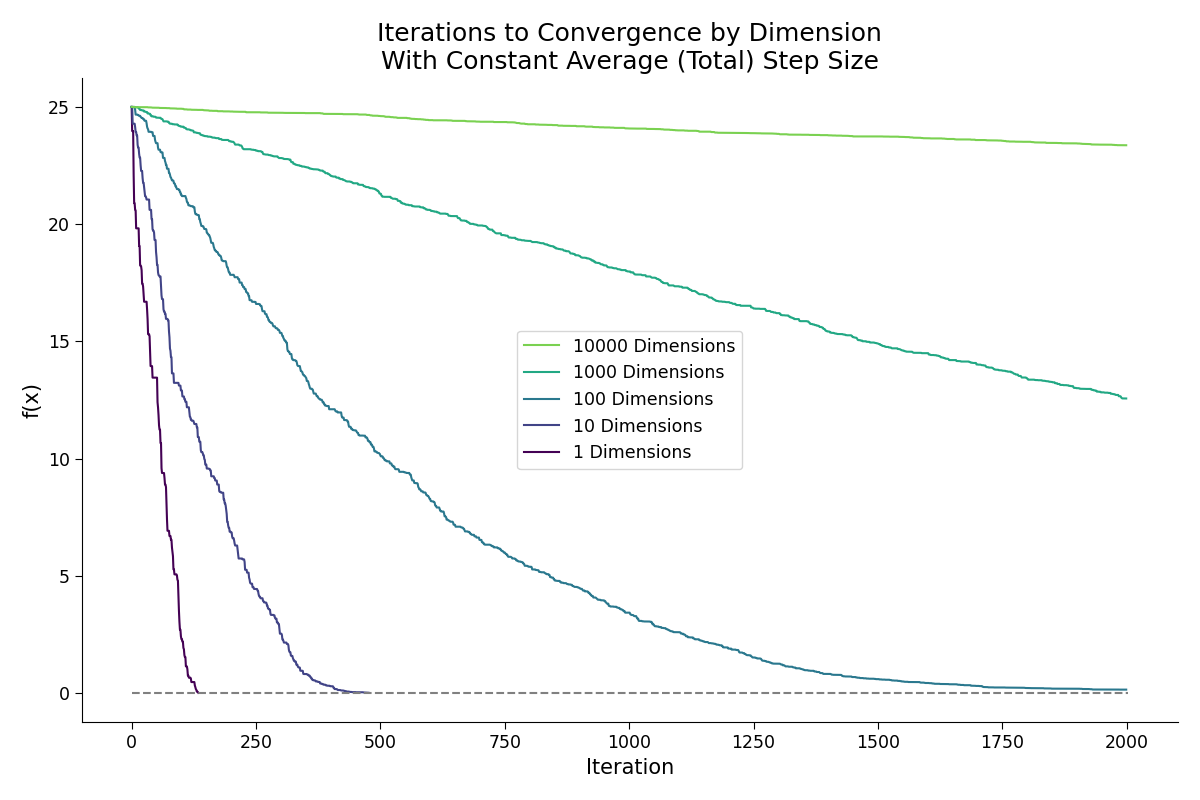

In [3]:
# @markdown **Run this cell** to see how iterations to convergence for propose-accept-reject changes as the number of dimensions increases
def simple_quadratic(x):
  return np.sum(x**2, axis=0)

def scale_stable_propose(x, step_size=0.1, rng=np.random.default_rng()):
  dim = x.shape[0]
  step_scale = step_size / np.sqrt(dim)
  proposed_x = x + rng.standard_normal(size=x.shape) * step_scale
  return proposed_x

def fixed_scale_propose(x, step_size=0.1, rng=np.random.default_rng()):
  proposed_x = x + rng.standard_normal(size=x.shape) * step_size
  return proposed_x

# propose accept reject loop
step_size = 0.1
max_proposals = 2000
starting_distance_from_optimal = 5
par_rng = np.random.default_rng(42)
N_Dim = [1, 10, 100, 1000, 10000] # number of dimensions
x_histories = []
z_histories = []
for N in N_Dim:
  x_history = []
  z_history = []
  num_proposed = 0
  num_accepted = 0
  # initialize x
  x = par_rng.standard_normal(size=N)
  x = x / np.linalg.norm(x) * starting_distance_from_optimal
  z = simple_quadratic(x)
  x_history.append(x)
  z_history.append(z)
  while z_history[-1] > step_size**2:
    proposed_x = scale_stable_propose(x, step_size=step_size, rng=par_rng)
    num_proposed += 1
    z_proposed = simple_quadratic(proposed_x)
    if z_proposed < z:
      x = proposed_x
      z = z_proposed
      num_accepted += 1
    x_history.append(x)
    z_history.append(z)
    if num_proposed > max_proposals:
      break
  x_histories.append(x_history)
  z_histories.append(z_history)

# Create subplots
fig, ax = plt.subplots(figsize=(12, 8))
cmap = plt.cm.viridis  # This colormap goes from light (yellow) to dark (blue)
colors = cmap(np.linspace(0, 1, len(N_Dim)+1))
# Plotting the data
for ii, z_history in enumerate(z_histories):
  if len(z_history) > max_proposals:
    z_history = z_history[:max_proposals]
  ax.plot(z_history, label=f'{N_Dim[ii]} Dimensions', color=colors[ii])
ax.hlines(step_size**2, 0, len(z_histories[-1]), linestyles='dashed', colors='gray')
ax.set_xlabel('Iteration')
ax.set_ylabel('f(x)')
ax.set_title('Iterations to Convergence by Dimension\nWith Constant Average (Total) Step Size')
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
labels.reverse()
ax.legend(handles, labels)
plt.show()

The proposals in propose-accept-reject are generated by adding Gaussian noise to the current $\mathbf{x}$ value that is

$$
\mathbf{x}_{\text{proposed}} = \mathbf{x}_{\text{current}} + \mathbf{\xi}
$$

with $\mathbf{\xi} \sim \sigma \cdot \mathcal{N}(\mathbf{0}, \mathbf{I})$. The average size of a perturbation, i.e., its Euclidean length $\|\mathbf{\xi} \|$, is given by

$$ \begin{align}
\mathbb{E}[\|\mathbf{\xi} \|] &= \mathbb{E}\left[\sqrt{\sum_{i=1}^n \xi_i^2}\right] = \sigma \mathbb{E}[\chi_n] = \sigma \sqrt{2} \frac{\Gamma\left(\frac{n+1}{2}\right)}{\Gamma\left(\frac{n}{2}\right)} \\
&\approx \sigma \sqrt{n} \ \text{for large } n.
\end{align}$$

Here $\chi_n$ denotes a chi distribution with $n$ degrees of freedom.This is the  distribution of the norm of a vector of $n$ independent standard normal random variables. ($\Gamma$ denotes the gamma function which is a generalization of the factorial function on integers to real and complex values.) For high dimensions, i.e., large $n$, the approximation $\sigma \sqrt{n}$ becomes increasingly accurate due to the central limit theorem.

To maintain a consistent average step length $s$ across different dimensions, it's necessary to scale $\sigma$ inversely with the square root of $n$, specifically $\sigma = \frac{s}{\sqrt{n}}$. Maintaining a constant $\sigma$ regardless of dimensionality leads to increasingly larger steps as $n$ grows, which can destabilize the optimization process. This is problematic as illustrated in the simulation below.

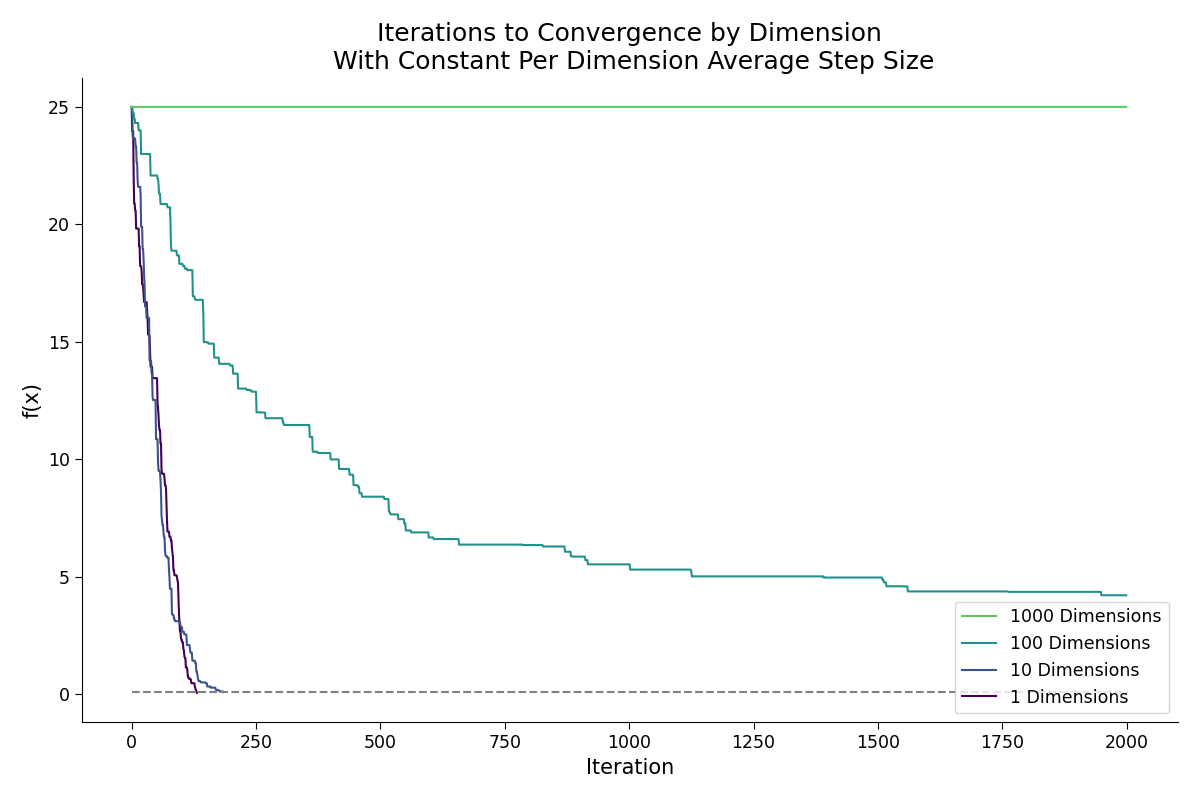

In [4]:
# @markdown **Run this cell** to see how having step size increase with dimension is a problem for propose-accept-reject.
# propose accept reject loop
step_size = 0.1
starting_distance_from_optimal = 5
par_rng = np.random.default_rng(42)
N_Dim = [1, 10, 100, 1000] # number of dimensions
x_histories = []
z_histories = []
max_proposals = 2000
for N in N_Dim:
  x_history = []
  z_history = []
  num_proposed = 0
  num_accepted = 0
  # initialize x
  x = par_rng.standard_normal(size=N)
  x = x / np.linalg.norm(x) * starting_distance_from_optimal
  z = simple_quadratic(x)
  x_history.append(x)
  z_history.append(z)
  while z_history[-1] > step_size:
    proposed_x = fixed_scale_propose(x, step_size=step_size, rng=par_rng)
    num_proposed += 1
    z_proposed = simple_quadratic(proposed_x)
    if z_proposed < z:
      x = proposed_x
      z = z_proposed
      num_accepted += 1
    x_history.append(x)
    z_history.append(z)
    if num_proposed > max_proposals:
      break
  x_histories.append(x_history)
  z_histories.append(z_history)

# Create subplots
fig, ax = plt.subplots(figsize=(12, 8))
cmap = plt.cm.viridis  # This colormap goes from light (yellow) to dark (blue)
colors = cmap(np.linspace(0, 1, len(N_Dim)+1))
# Plotting the data
for ii, z_history in enumerate(z_histories):
  if len(z_history) > max_proposals:
    z_history = z_history[:max_proposals]
  ax.plot(z_history, label=f'{N_Dim[ii]} Dimensions', color= colors[ii])
ax.hlines(0.1, 0, len(z_histories[-1]), linestyles='dashed', colors='gray')
ax.set_xlabel('Iteration')
ax.set_ylabel('f(x)')
ax.set_title('Iterations to Convergence by Dimension\n With Constant Per Dimension Average Step Size')
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
labels.reverse()
ax.legend(handles, labels)
plt.show()

Having step size scale up with dimension can lead to fast convergence at first (bigger step sizes means you get where you're going more quickly) but at some point large step sizes make it more difficult to zero in on the exact location of the optimal value. Larger step sizes limit percision, eventually to the point where no improvment is made.

Now that we've seen what increasing the number of dimensions does to convergence rate of propose-accept-reject, let's take a look at perturb-measure-step.

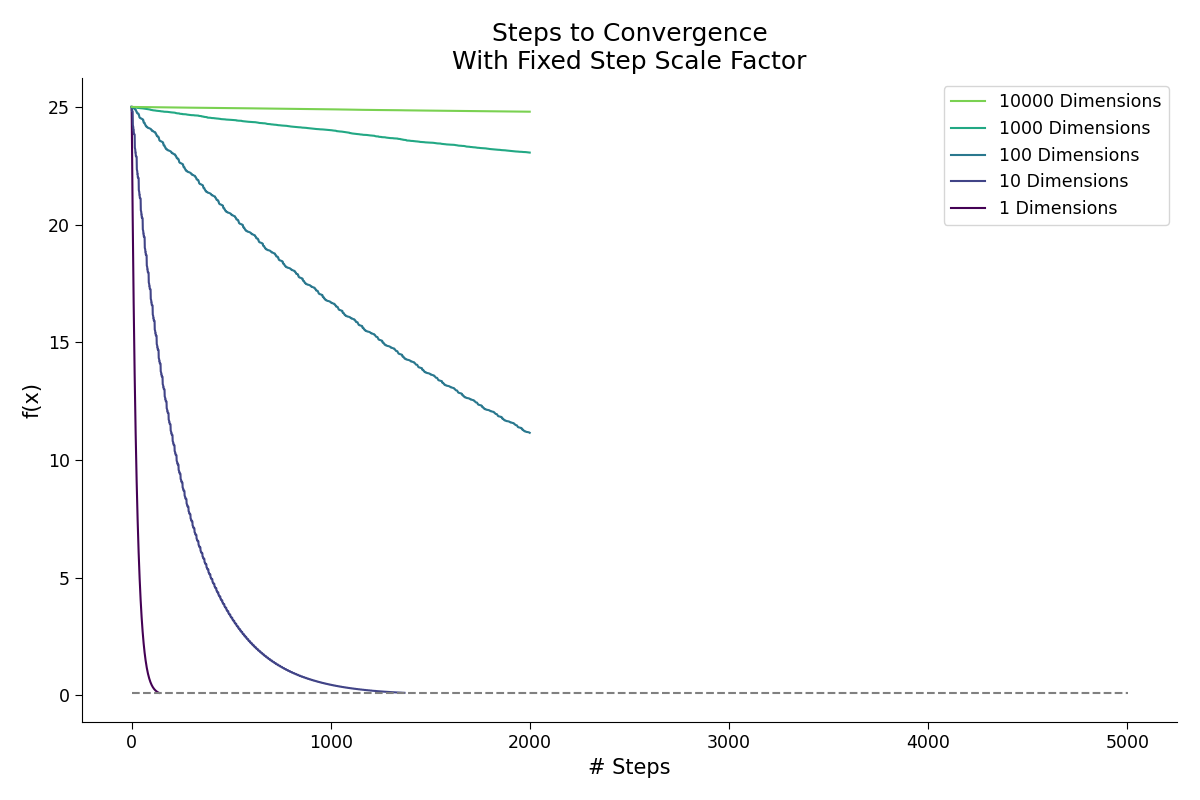

In [5]:
# @markdown **Run this cell** to look at convergence rates in different dimensions for perturb-measure-step
test_perturb = 0.00001
step_scale = 0.01
starting_distance_from_optimal = 5
pms_rng = np.random.default_rng(42)
N_Dim = [1, 10, 100, 1000, 10000] # number of dimensions
x_histories = []
z_histories = []
max_steps = 5000
for N in N_Dim:
  x_history = []
  z_history = []
  num_steps = 0
  num_function_evaluations = 0
  # initialize x
  x = par_rng.standard_normal(size=N)
  x = x / np.linalg.norm(x) * starting_distance_from_optimal
  z = simple_quadratic(x)
  num_function_evaluations += 1
  x_history.append(x)
  z_history.append(z)
  while z_history[-1] > step_size:
    for dim in range(N):
      x[dim] += test_perturb #perturb
      z_test = simple_quadratic(x) #test
      x[dim] -= test_perturb # un-perturb
      dim_grad_est = (z_test - z) / test_perturb #measure slope
      x[dim] -= step_scale * dim_grad_est #step
      num_steps += 1
      z = simple_quadratic(x)
      num_function_evaluations += 2
      x_history.append(x)
      z_history.append(z)
      if num_steps > max_steps:
        break
    if num_steps > max_steps:
      break
  x_histories.append(x_history)
  z_histories.append(z_history)

fig, ax = plt.subplots(figsize=(12, 8))
cmap = plt.cm.viridis  # This colormap goes from light (yellow) to dark (blue)
colors = cmap(np.linspace(0, 1, len(N_Dim)+1))
# Plot each dimensions history
for ii, z_history in enumerate(z_histories):
  if len(z_history) > max_proposals:
    z_history = z_history[:max_proposals]
  ax.plot(z_history, label=f'{N_Dim[ii]} Dimensions', color= colors[ii])
ax.hlines(0.1, 0, len(z_histories[-1]), linestyles='dashed', colors='gray')
ax.set_xlabel('# Steps')
ax.set_ylabel('f(x)')
ax.set_title('Steps to Convergence\nWith Fixed Step Scale Factor')
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
labels.reverse()
ax.legend(handles, labels)
plt.show()

The number of iterations here to convergence increases with dimension, partly because, this version of perturb-measure-step basically treats each dimension in isolation. It perturbs, then measures, thens step in one dimension before moving on to the next, so $n$ steps are required to make improvements in all $n$ dimensions. In the case above where we have 10,000 dimensions, but only run for 2000 steps, 8000 of the elements of $\mathbf{x}$ have been not been improved upon at all. Scale is important for the brain. Recall that there are trillions of synapses in the brains of brainy animals. Learning in the brain requires optimzation algorithms that are effective in high dimensions. The rest of the book is dedicated to learning about algorithms that scale well in this sense, but before we get to those we want to spend just a little more time understanding how and why these two algorithms, propose-accept-reject and perturb-measure-step, slow down the way they do in higher dimensions.

In [6]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M2")

# 2.1.3.3 How and Why Propose-Accept-Reject Slows Down in Higher Dimensions

The proposals in propose-accept-reject are generated by adding Gaussian noise to the current $\mathbf{x}$ value that is
$$
\mathbf{x}' = \mathbf{x} + \mathbf{\xi}
$$
with $\mathbf{\xi} \sim \frac{s}{\sqrt{n}} \cdot \mathcal{N}(\mathbf{0}, \mathbf{I})$. We scale each perturbation by $\frac{s}{\sqrt{n}}$ so that $\mathbb{E}\left[\| \mathbf{\xi} \|\right] = s$. If we reject a proposal the improvement is zero.

To get some intuition about this process let's start with a point in our simple quadratic function, and then sample lot's of Gaussian proposals around that point. If the proposal results in an improvement we will measure the angle between the direction of maximal improvment (the gradient) the proposal that would have been accepted. Then we will plot the distribution of these angles of proposals that would be accepted.



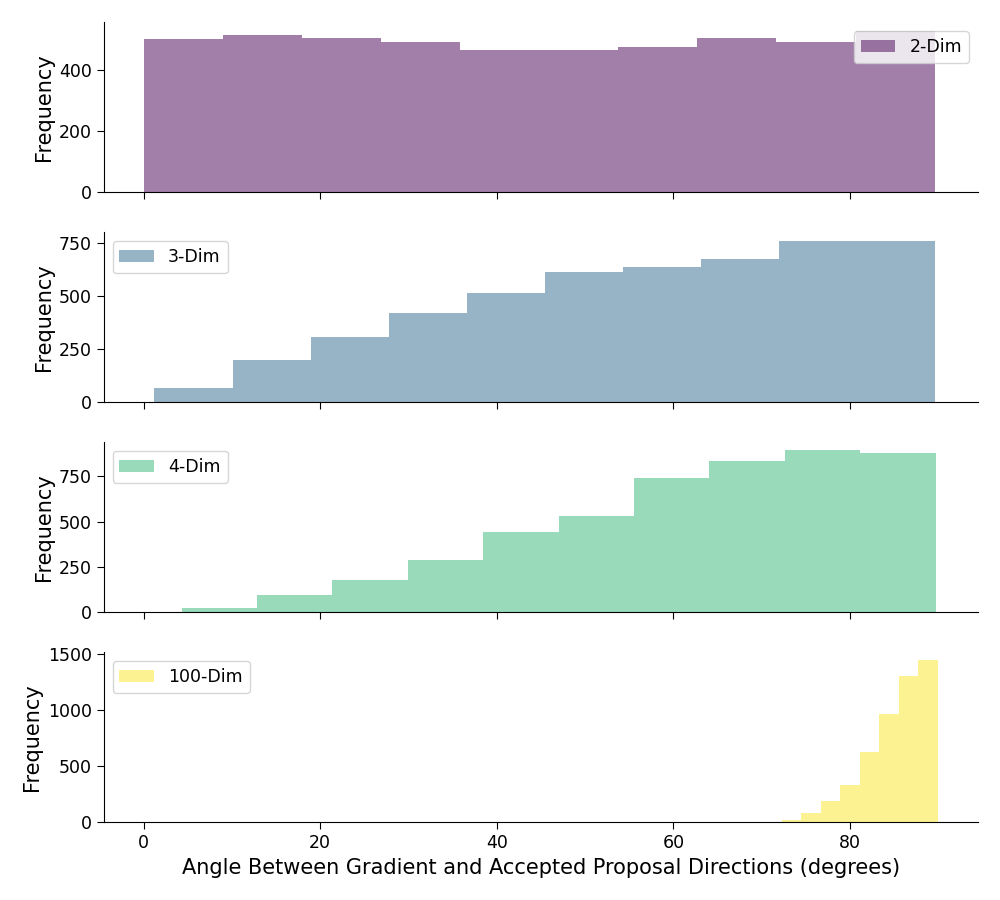

In [7]:
# @markdown **Run this cell** to see how the distribution of angles of divergence between accepepted proposals and the gradient changes with the number of dimensions.
def simple_quadratic(x):
    return np.sum(x**2, axis=0)

N_Dim = [2, 3, 4, 100]
sample_rng = np.random.default_rng(0)
step_size = 0.1
starting_distance_from_optimal = 5
num_samples = 10000

fig, axes = plt.subplots(nrows=len(N_Dim), sharex=True, figsize=(10, 9))
colors = plt.cm.viridis(np.linspace(0, 1, len(N_Dim)))  # Colormap to differentiate dimensions
remove_ip_clutter(fig)

for idx, N in enumerate(N_Dim):
  raw_x = sample_rng.standard_normal(size=N)
  unit_x = raw_x / np.linalg.norm(raw_x)
  x = unit_x * starting_distance_from_optimal
  unit_grad_x = unit_x[:, np.newaxis]  # reshape for broadcasting
  current_z = simple_quadratic(x)
  samples = sample_rng.standard_normal(size=(N, num_samples))
  unit_samples = samples / np.linalg.norm(samples, axis=0, keepdims=True)
  test_points = x[:, np.newaxis] + unit_samples * step_size / np.sqrt(N)
  test_evals = simple_quadratic(test_points)
  accepted_index = test_evals < current_z
  proportion_accepted = np.sum(accepted_index) / num_samples
  accepted_proposal_directions = unit_samples[:, accepted_index]
  dot_product = np.sum(accepted_proposal_directions * -unit_grad_x, axis=0)
  angle_from_grad = np.arccos(np.clip(dot_product, -1.0, 1.0))
  angles_in_degrees = np.degrees(angle_from_grad)
  ax = axes[idx]
  ax.hist(angles_in_degrees, alpha=0.5, color=colors[idx], label=f'{N}-Dim')
  if idx == len(N_Dim)-1:
    ax.set_xlabel('Angle Between Gradient and Accepted Proposal Directions (degrees)')
  ax.legend()
  ax.set_ylabel('Frequency')
plt.show()

Looking at these plots we see that in only 2-dimensions, a random accepted proposal direction has an angle of divergence from the gradient that is uniformly distributed between 0 and 90 degrees. As we go into higher dimensions this distribution skews towards 90 degrees (less aligned). Roughly, the intuition here is that by only accepting proposals that lead to improvement we ensure some alignment with the gradient direction, i.e. we only accept angles of divergence below 90 degrees). But, in higher dimensions there is a real sense in which there are more more directions to go in, and so the degree of alignment between a random direction and any particular direction converges towards 90 degrees. Put another way, in high dimensional spaces two random directions are almost totally perpendicular to eachother. This is very different from what we may be used to when thinking about directions in two and three dimensional spaces, and is at the root of why perturb-measure-step and propose-accept-reject slow down in high dimensions, there are simply more directions to go, more directions to be explored.

## Propose-Accept-Reject Analysis
What does this fact about high-dimensional spaces (that most directions are perpendicular to eachother) mean for the expected improvement from applying an iteration propose-accept-reject?

We're going to step away from our simple quadratic function and try to say something a little more general, using an analytical approach. For this we consider a function $f(\mathbf{x})$ that is *analytic*. This has a precise mathematical meaning, but intuitively it means that the function is not pathologically wiggly. More formally, an analytic function can be locally expressed by a convergent power series. For our purposes, this implies smoothness and the absence of abrupt changes, which in turn allows for reliable use of linear approximations in the vicinity of any point within its domain. Specifically, the function can be approximated as:

$$
f(\mathbf{x} + \mathbf{p}) \approx f(\mathbf{x}) + \mathbf{p} \cdot \mathbf{g}
$$

where $\mathbf{g} = \nabla f(\mathbf{x}) = \left. \left(\frac{\partial f}{\partial x_1}, \frac{\partial f}{\partial x_2}, \dots, \frac{\partial f}{\partial x_n} \right)\right|_{\mathbf{x}}$ is the gradient of $f$ evalutated at $\mathbf{x}$, $\mathbf{p}$ is a small perturbation vector in $\mathbb{R}^n$, and $\mathbf{p} \cdot \mathbf{g}$ is the inner product of the two vectors.
Note that this approximation is only good when the perturbation $\mathbf{\p}$ is sufficiently small. Our assumption about $f$ being analytic means that we can make this approximation arbitrarily good, by making $\mathbf{p}$ smaller, specifically as $\|\mathbf{\delta}\|$ decreases in magnitude, higher-order terms in the Taylor expansion of $f$ at $\mathbf{x}$ become insignificant, and the linear approximation becomes increasingly accurate.

Now we ask, for any analytic function, at any point $\mathbf{x}$, with a given step size $s$, what is the average expected improvement from a single interation of the propose-accept-reject algorithm, and how does this expected improvement compare to the 'best possible' improvement of taking a step of size $s$ in the direction of the gradient?

We haven't said what $\mathbf{g}$ is or what $f$ is, so at first glance it may seem crazy to try and compute this, but we're about to do a sneaky math trick so pay attention. We're going to do a change of coordinates. The perturbations that we use in propose-accept-reject, $\mathbf{\xi}$, are samples from a little Guassian cloud, and the density of this cloud is isotropic. Isotropic means the same in all radial dimensions, so that any rigid rotation of coordinates leaves the distribution totally unchanged. Now, $\mathbf{g}$ can be re-written as the product of a unit direction vector $\frac{\mathbf{g}}{\|\mathbf{g}\|}$ and a magnitude $\|\mathbf{g}\|$. Then we can rotate our coordinate axis so that our first coordinate dimension is perfectly aligned with the gradient, and all other $n-1$ dimensions are perfectly unaligned, i.e. perpendicular, to the gradient. In this new coordinate system $\mathbf{g} = \|\mathbf{g}\|(1, 0, \cdots, 0)$, and then the inner product, $\xi \cdot \mathbf{g}$, is simply $$(\xi_1 \cdot 1 + \xi_2 \cdot 0 + \dots + \xi_n \cdot 0) \|\mathbf{g}\| = \xi_1 \|\mathbf{g}\|$$

Now that is the inner product of the gradient with any proposal, but we are interested in the inner product between the gradient and an accepted proposal, that is $\mathbb{E}\left[\xi_1 | \text{Proposal Accepted} \right] = s \sqrt{\frac{2}{n \pi}}$, since the proposal will only be accepted if $\xi_1 > 0$, so while $\xi_1$ follows a normal distribution with $\sigma = \frac{s}{\sqrt{N}}$, when we condition on acceptance $\xi_1 | \text{acceptance}$ follows a half-normal or chi-squred with one degree of freedom, $\chi_1$, distribution.

The mean of a half-normal distribution is known to be the standard deviation of the underlying normal distribution, in our case, $\frac{s}{\sqrt{n}}$ scaled by $\sqrt{\frac{2}{\pi}}$. This gives us the expected improvement from an accepted proposal as
$$s \|\mathbf{g}\| \sqrt{\frac{2}{n \pi}}$$

Now by the symmetry of the normal distribution, we can see that half of the time our proposals will be rejected and half of the time they will be accepted. When a proposal is rejected there is zero improvement. Taking the average over cases when the proposal is accepted and when it is rejected we have an expected improvement of
$$ \frac{s\|\mathbf{g}\|}{\sqrt{2\pi n}}$$

Now if we were to just know the direction of $\mathbf{g}$ and step $s$ in that direction, the improvement would be $s\|\mathbf{g}\|$. So we see that the rate of improvement relative to the optimally oriented small step is reduced by a factor of $\frac{1}{\sqrt{2 \pi n }}$. Intuitively as the number of dimensions increases, random step directions are less and less likely to be well aligned with this optimal direction. Note that if we were to use our 'always-step' variant of propose-accept-reject, we could do a little better with
$$s \|\mathbf{g}\| \sqrt{\frac{2}{n \pi}}$$ but we would still have our expected improvement per step drop of with $\frac{1}{\sqrt{n}}$

Another way to think about this, is that our acceptance criteria means we take steps that are oriented in the same half-space as the gradient. The average of many such steps will converge on the gradient, but convergence will be slow in high dimensions, since accepted proposals are a very noisy (though un-biased) estimator of the gradient. Run the following cell to see how pooling together many accepted proposal gives better alignement (closer to zero degrees of divergence), with the direction of greatest improvement, the gradient.

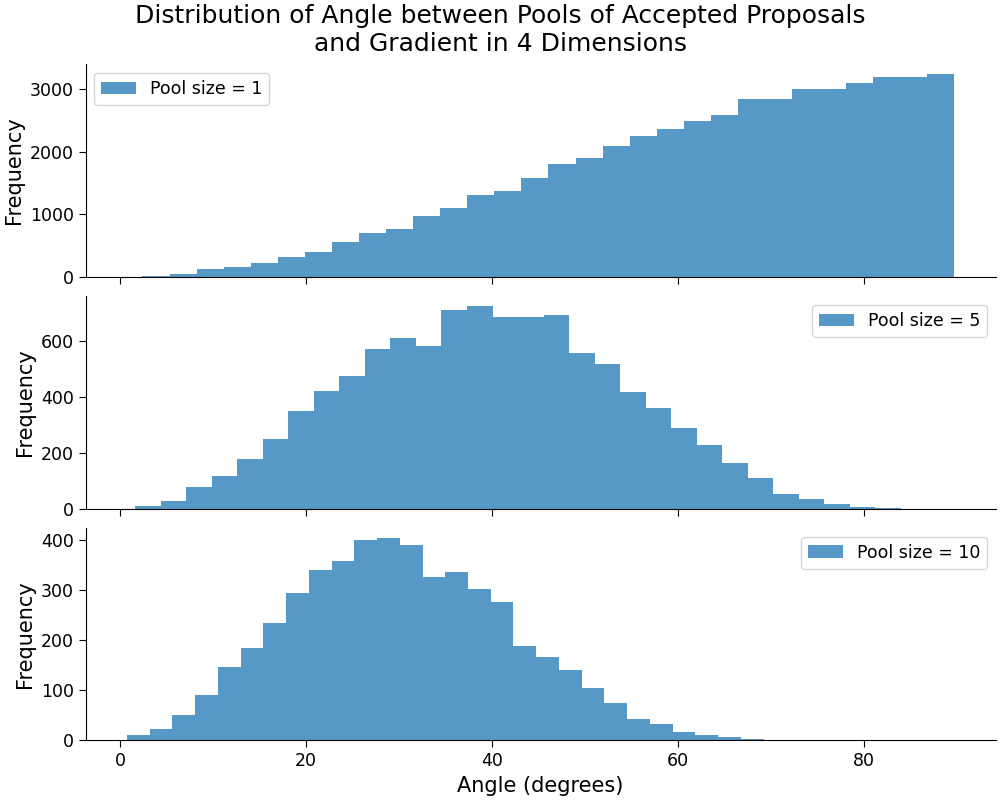

In [8]:
# @markdown **Run this cell** to see how the average of many accepted proposals has increased alignment with the gradient.
N = 4  # Fixed dimension
pool_sizes = [1, 5, 10]  # Different sizes of accepted samples to average
sample_rng = np.random.default_rng(0)
step_size = 0.1
starting_distance_from_optimal = 5
num_samples = 100000

fig, axes = plt.subplots(nrows=len(pool_sizes), sharex=True, figsize=(10, 8), constrained_layout=True)
fig.suptitle('Distribution of Angle between Pools of Accepted Proposals\nand Gradient in 4 Dimensions')

raw_x = sample_rng.standard_normal(size=N)
unit_x = raw_x / np.linalg.norm(raw_x)
x = unit_x * starting_distance_from_optimal
unit_grad_x = unit_x  # Reshape removed as it's not necessary for dot product calculation
current_z = simple_quadratic(x)
samples = sample_rng.standard_normal(size=(N, num_samples))
unit_samples = samples / np.linalg.norm(samples, axis=0, keepdims=True)
test_points = x[:, np.newaxis] + unit_samples * step_size / np.sqrt(N)
test_evals = simple_quadratic(test_points)
accepted_index = test_evals < current_z
accepted_proposal_directions = unit_samples[:, accepted_index]

for idx, sample_size in enumerate(pool_sizes):
  ax = axes[idx]
  num_groups = accepted_proposal_directions.shape[1] // sample_size
  angles_in_degrees = []
  for i in range(num_groups):
    # Compute the mean direction for each group
    group_pooled_direction = np.sum(accepted_proposal_directions[:, i * sample_size:(i + 1) * sample_size], axis=1)
    group_unit_direction = group_pooled_direction / np.linalg.norm(group_pooled_direction)  # Normalize
    dot_product = np.dot(group_unit_direction, -unit_grad_x)
    angle_from_grad = np.arccos(np.clip(dot_product, -1.0, 1.0))
    angles_in_degrees.append(np.degrees(angle_from_grad))

  ax.hist(angles_in_degrees, bins=30, alpha=0.75, label=f'Pool size = {sample_size}')
  if idx == len(pool_sizes)-1:
    ax.set_xlabel('Angle (degrees)')
  ax.set_ylabel('Frequency')
  ax.legend()

plt.show()

Now let's just check that our analysis lines up with a simulation

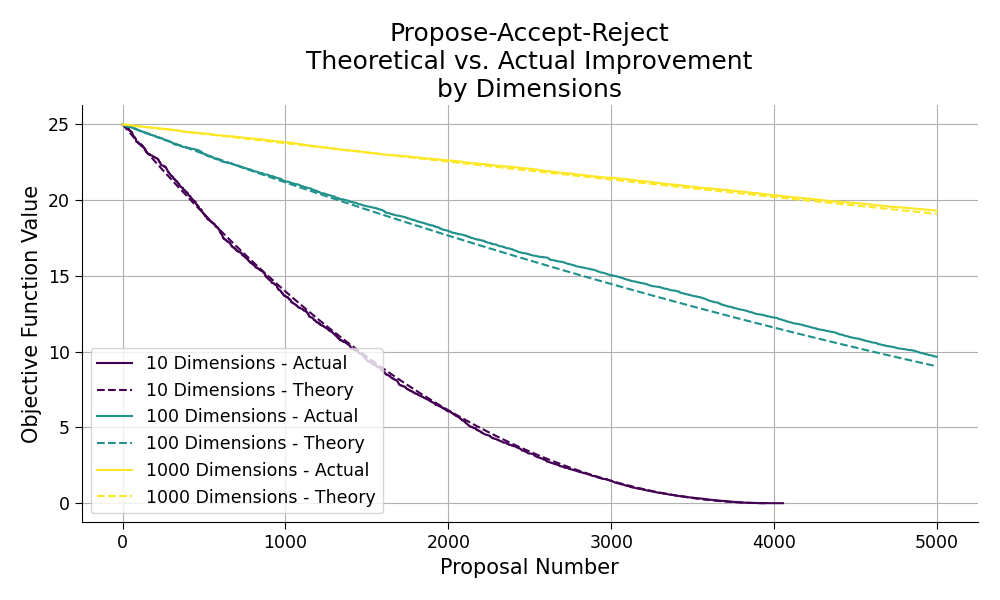

In [9]:
# @markdown **Run this cell** to compare our theoretical expected rate of improvement with the actual rate of improvement for propose-accept-reject

def simple_quadratic(x):
  return np.sum(x**2)

def grad_simple_quadratic(x):
  return 2 * x

def scale_stable_propose(x, step_size, rng=np.random.default_rng()):
  dim = x.shape[0]
  step_scale = step_size / np.sqrt(dim)
  proposed_x = x + rng.standard_normal(size=x.shape) * step_scale
  return proposed_x

def expected_par_improvement(x, step_size):
  dim = x.shape[0]
  grad_x = grad_simple_quadratic(x)
  grad_norm = np.linalg.norm(grad_x)
  expected_improvement = step_size * grad_norm * np.sqrt(1 / (2 * dim * np.pi))
  return expected_improvement

def expected_par_improvement_z(z, dim, step_size):
  grad_norm = 2 * np.sqrt(z)
  expected_improvement = step_size * grad_norm * np.sqrt(1 / (2 * dim * np.pi))
  return expected_improvement

# Propose-accept-reject loop
def propose_accept_reject(N_Dim, step_size, max_proposals, starting_distance_from_optimal, rng=None):
  if rng is None:
    rng = np.random.default_rng(0)
  z_histories = []
  actual_improve_histories = []
  expected_improve_histories = []
  for N in N_Dim:
    x = rng.standard_normal(size=N)
    x = x / np.linalg.norm(x) * starting_distance_from_optimal
    z = simple_quadratic(x)
    z_history = [z]
    expected_improve_history = []
    actual_improve_history = []
    num_proposed = 1
    while z > step_size**2 and len(z_history) < max_proposals:
      expected_improve_history.append(expected_par_improvement(x, step_size))
      proposed_x = scale_stable_propose(x, step_size=step_size, rng=par_rng)
      z_proposed = simple_quadratic(proposed_x)
      if z_proposed < z:
        x = proposed_x
        actual_improve_history.append(z - z_proposed)
        z = z_proposed
      else:
        actual_improve_history.append(0)
      z_history.append(z)
    z_histories.append(z_history)
    expected_improve_histories.append(expected_improve_history)
    actual_improve_histories.append(actual_improve_history)
  return z_histories, expected_improve_histories, actual_improve_histories

def expectation_propose_accept_reject(N_Dim, step_size, max_proposals, starting_distance_from_optimal, rng=None):
  if rng is None:
    rng = np.random.default_rng(0)
  z_histories = []
  for N in N_Dim:
    x = rng.standard_normal(size=N)
    x = x / np.linalg.norm(x) * starting_distance_from_optimal
    z = simple_quadratic(x)
    z_history = [z]
    num_proposed = 1
    while z > step_size**2 and len(z_history) < max_proposals:
      expected_improvement = expected_par_improvement_z(z, N, step_size)
      z = z - expected_improvement
      z_history.append(z)
    z_histories.append(z_history)
  return z_histories

# Parameters for specific dimensions of interest
N_Dim = [10, 100, 1000]
step_size = 0.01
max_proposals = 5000
starting_distance_from_optimal = 5

# Run the simulation
z_histories, expected_improve_histories, actual_improve_histories = propose_accept_reject(N_Dim, step_size, max_proposals, starting_distance_from_optimal)
expectation_z_histories = expectation_propose_accept_reject(N_Dim, step_size, max_proposals, starting_distance_from_optimal)

# Plotting with color gradient
fig, ax = plt.subplots(figsize=(10, 6))
cmap = plt.cm.viridis  # Color map
colors = cmap(np.linspace(0, 1, len(N_Dim)))

for ii, N in enumerate(N_Dim):
  ax.plot(z_histories[ii], label=f'{N} Dimensions - Actual', color=colors[ii])
  ax.plot(expectation_z_histories[ii], label=f'{N} Dimensions - Theory', color=colors[ii], linestyle='--')

ax.set_xlabel('Proposal Number')
ax.set_ylabel('Objective Function Value')
ax.set_title('Propose-Accept-Reject\nTheoretical vs. Actual Improvement\nby Dimensions')
ax.legend()
plt.grid(True)
plt.show()


_____________________________
## Thought Box: Simulation and Analyses as Complementary Intellectual "Senses"

In general it is good to sense check analytical results against a simulation, and simulation result against analystic results when possible. Analyses and simulation are like two distinct quantitative senses. Much as animals correlate and corroborate the information coming along the different sensory channels of sight, sound, touch, smell to build up a robust model of the world, when exploring ideas intellectually, we should treat simulation and analysis as complementary "senses" for the abstract and qunatitative aspects of the world. Note though that agreement between analysis and simulation is not anything like a proof. Even if they agree, there may still be an error in one or both. The value of comparison arises because if the two do disagree then we know for certain there must be at least one error somewhere!

Culturally, mathematicians choose to focus on the "analysis" sense, and rely on it solely when constructing their proofs. (Though "proof" is itself a culturally constructed phenomena.) There are epistemological reasons for prioritizing rational analysis, and before the advent of widespread access to relatively inexpensive mechanical computers there were also strong practical reasons for prioritizing this. However, especially when we are interested in connecting our abstract analyses up measured observations of the world, using simulation as means of forcing all implicit assumptions to become explicit, serves as a helpful intermediate, between the fully abstract realm of analysis, and fully concrete empirical observations.
__________________________________

Given the agreement between our simulations and our analysis we have some confidence in both, so now let's turn our attention to perturb-measure-step

In [10]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M3")

# 2.1.3.4 How and Why Perturb-Measure-Step Slows Down in Higher Dimensions

In pertrub-measure-step we iterate through the dimensions generating a test point according to
$$
\mathbf{x}' = \mathbf{x} + s_{\text{test}}\mathbf{e}^i
$$
Where $\mathbf{e}^i$ is an ortho-normal basis vector for the $i^{th}$ dimension. By measuring the change caused by this perturbation we can get a good estimate of the $g_i$, the component of the gradient in along the $i^{th}$ coordinate dimension. Based on this estimate of $g_i$ we then steps $s \cdot g_i$ in the $i^{th}$ dimension. Now because we don't know anything about the particular structure of $\mathbf{g}$ and the function $f$, it hard to say much about what kind of improvement we will get out of any one step in any one dimension. But we do know that after iterating through all $n$ dimensions we will have taken a step roughly in the direction of the gradient, and that the length of this combination of $n$-steps is $\sqrt{\sum_{i=1}^{n} s^2 g_i^2} = s \|\mathbf{g}\| $. Now the rate of improvement in the direction of the gradient is $\|\mathbf{g}\|$, so the expected improvement over $n$ steps will be roughly $ s\|\mathbf{g}\|^2$. Then on average, each step will contribute an improvement of

$$\frac{s\|\mathbf{g}\|^2}{n}$$

The rate of improvement for perturb-measure-step drops off with $\frac{1}{n}$, even faster than that of propose-accept-reject. This analysis is a little loose, since $\mathbf{g}$ will change slightly as steps are taken, but it could be tightened up by analyzing a more tractable "stochastic" variant of pertrub-measure-step, in which instead of iterating through the directions systematically, a random direction is chosen for perturbation. This random direction could be chosen from the $n$ orthonormal basis directions, in which case the analysis is much as above, or the direction could be choose uniformly over all possible directions, i.e. using $$
\mathbf{x}' = \mathbf{x} + s_{\text{test}}\frac{\xi}{\|\xi\|}
$$
With $\mathbf{\xi} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$. (This shoud be starting to remind you of our analysis of propose-accept-reject.)

That's the perturbation. Now we want to measure the improvement in the direction of the perturbation. Which, can be computed as follows for small perturbations (because our function is analytic),
$$\frac{\Delta f(\mathbf{x})}{\|\xi \|} \approx \frac{\xi \cdot \mathbf{g}}{\| \xi \|}$$

Then we can do our same coordinate rotating trick to get the expected measured rate of improvement in the direction of $\xi$ as
$$ \frac{\xi \cdot \mathbf{g}}{\| \xi \|}  = \frac{\| \mathbf{g}\|}{\| \mathbf{\xi}\|} (\xi_1 \cdot 1 + \xi_2 \cdot 0 + \dots + \xi_n \cdot 0) = \xi_1 \frac{\| \mathbf{g}\|}{\| \mathbf{\xi}\|}$$.

The algorithm will then takes a step proportional to the rate of improvement, i.e. of length $s \xi_1 \frac{\| \mathbf{g}\|}{\| \mathbf{\xi}\|}$ in the direction of $\xi$ and this will result in an expected improvement of $$ s \| \mathbf{g}\|^2  \frac{\xi_1^2}{\| \mathbf{\xi}\|^2}$$.

$\xi_1^2$ \| follows a $\chi^2_1$ distribution and $\|\mathbf{\xi}\|^2$ follows a $\chi^2_n$ distribution. The normalized ratio of independent $\chi^2$ distributions follows an F-distribution, i.e.
$$ n \frac{\chi^2_1}{\chi^2_n} \sim F(1,n)$$

In our case, $\xi_1^2$ and $\|\mathbf{\xi}\|^2$ are not independent at all. Just the opposite, $\xi_1$ is a component of the sum that determines $\|\mathbf{\xi}\|^2$, but for large $n$ this contribution becomes negligable and we can approximate the true distribution using an F-distribution, that is

$$\mathbf{E}\left[ s \| \mathbf{g}\|^2  \frac{\xi_1^2}{\| \mathbf{\xi}\|^2}\right] \approx \frac{s \| \mathbf{g}\|^2}{n-2}$$

In either version of perturb-measure-step the expected improvement per step drops off like $\frac{1}{n}$ as the number of dimensions increases.

Now this 'stochastic' perturb-measure-step might seem a lot like propose-accept-reject on the face of things, and they are indeed deeply related. Both essentially take a step in a radom direction that is oriented in the same half-space as the gradient (or negative of the gradient if we are minimizing). But, whereas propose-accept-reject has a fixed average step size of $s$, perturb-measure-step, *scales* its step size by factor of $s$ while taking steps *proportional* to the rate of improvement in the tested direction. Thus if the test direction happens to be relatively well aligned with the gradient, it will take a bigger step, and if the test direction is relatively less aligned with gradient a smaller step is taken.

Again, we sense check these analyses against a simulation.

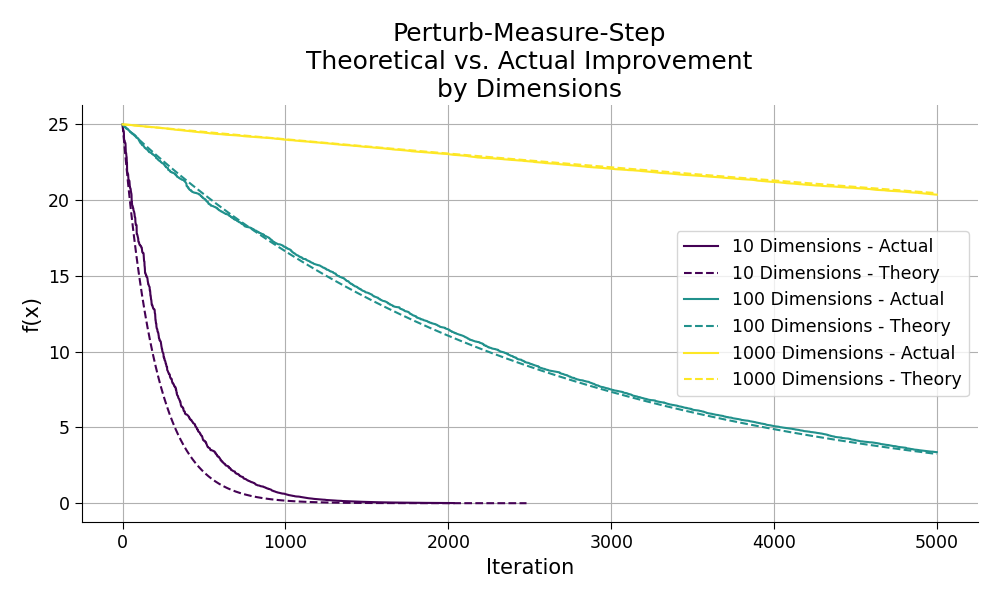

In [11]:
def simple_quadratic(x):
  return np.sum(x**2)

def grad_simple_quadratic(x):
  return 2 * x

def expected_pms_improvement(x, step_size):
  dim = x.shape[0]
  grad_x = grad_simple_quadratic(x)
  grad_norm = np.linalg.norm(grad_x)
  expected_improvement = step_size * grad_norm**2 / (dim-2)
  return expected_improvement

def expected_pms_improvement_z(z, dim, step_size):
  grad_norm = 2 * np.sqrt(z)
  expected_improvement = step_size * grad_norm**2 / (dim -2)
  return expected_improvement

def stochastic_perturb_measure_step(N_Dim, step_scale, max_steps, perturbation_scale, starting_distance_from_optimal, rng=None):
  if rng is None:
    rng = np.random.default_rng(42)
  histories = []
  for N in N_Dim:
    x = rng.standard_normal(size=N)
    x = x / np.linalg.norm(x) * starting_distance_from_optimal
    z = simple_quadratic(x)
    z_history = [z]
    while z > step_scale and len(z_history) < max_steps:
      raw_test_perturb = rng.standard_normal(size=N)
      unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb)
      test_perturbation = unit_test_perturb * perturbation_scale
      z_test = simple_quadratic(x + test_perturbation)
      directional_grad_est = (z_test - z) / perturbation_scale
      x -= step_scale * directional_grad_est * unit_test_perturb
      z = simple_quadratic(x)
      z_history.append(z)
    histories.append(z_history)
  return histories

def expectation_perturb_measure_step(N_Dim, step_scale, max_steps, perturbation_scale, starting_distance_from_optimal, rng=None):
  if rng is None:
    rng = np.random.default_rng(0)
  z_histories = []
  for N in N_Dim:
    x = rng.standard_normal(size=N)
    x = x / np.linalg.norm(x) * starting_distance_from_optimal
    z = simple_quadratic(x)
    z_history = [z]
    while z > step_size**2 and len(z_history) < max_proposals:
      expected_improvement = expected_pms_improvement_z(z, N, step_size)
      z = z - expected_improvement
      z_history.append(z)
    z_histories.append(z_history)
  return z_histories

  # Parameters for specific dimensions of interest
N_Dim = [10, 100, 1000]
step_scale = 0.01
perturbation_scale = 0.0001
max_steps = 5000
starting_distance_from_optimal = 5

# Run the simulation
z_histories = stochastic_perturb_measure_step(N_Dim, step_scale, max_steps, perturbation_scale, starting_distance_from_optimal)
expectation_z_histories = expectation_perturb_measure_step(N_Dim, step_scale, max_steps, perturbation_scale, starting_distance_from_optimal)

# Plotting with color gradient
fig, ax = plt.subplots(figsize=(10, 6))
cmap = plt.cm.viridis  # Color map
colors = cmap(np.linspace(0, 1, len(N_Dim)))

for ii, N in enumerate(N_Dim):
  ax.plot(z_histories[ii], label=f'{N} Dimensions - Actual', color=colors[ii])
  ax.plot(expectation_z_histories[ii], label=f'{N} Dimensions - Theory', color=colors[ii], linestyle='--')

ax.set_xlabel('Iteration')
ax.set_ylabel('f(x)')
ax.set_title('Perturb-Measure-Step\nTheoretical vs. Actual Improvement\nby Dimensions')
ax.legend()
plt.grid(True)
plt.show()

For $n=10$ our $F$-distribution approximation is likely not so good, but for higher dimensions the analysis seems to agree with the simulations.

Now, from our analysis we have that perturb-measure-step slows down like $\frac{1}{n}$ whereas propose-accept-reject slows down like $\frac{1}{\sqrt{n}}$. This means, that even if perturb-measure-step is faster in for some low-dimensional problems, eventually, as the number of dimensions, $n$, increases, propose-accept-reject will be a "better" algorithm, assuming of course that we leave step-size and step-scaling factor $s$ fixed as we increase the dimension. For this simple quadratic problem, let's see when that transition occurs.

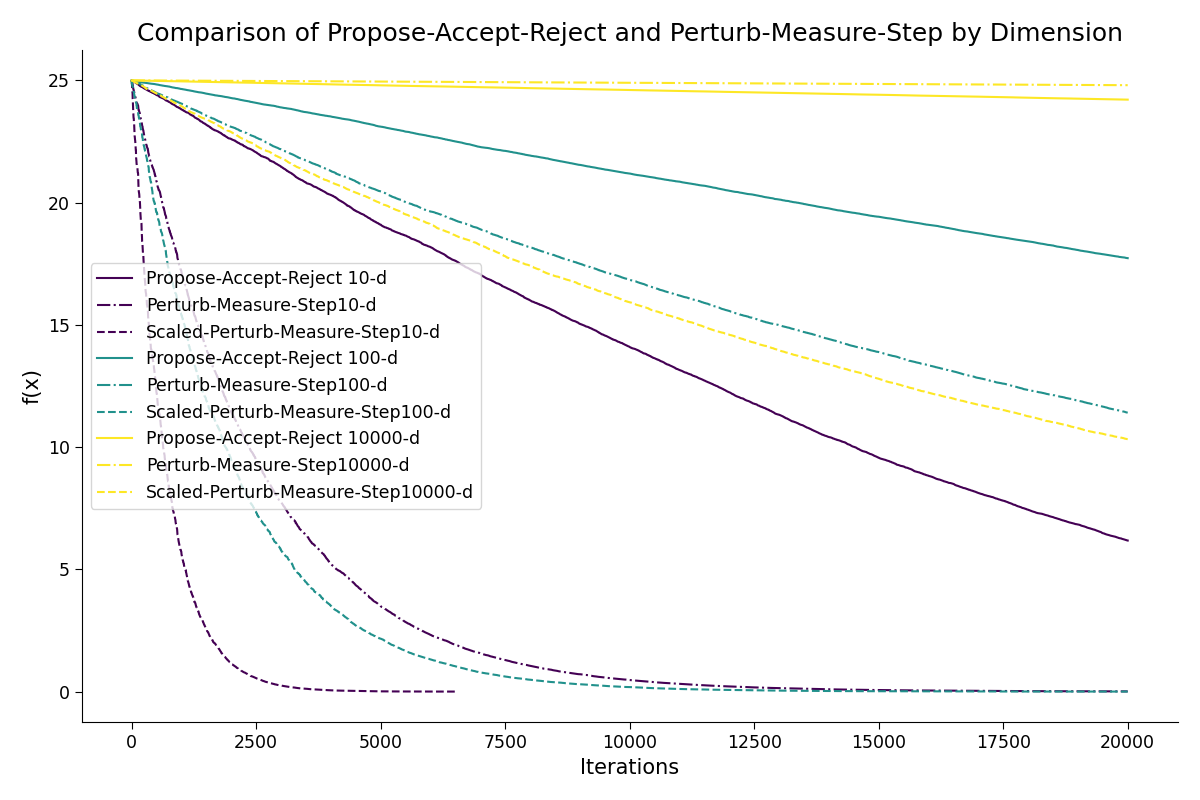

In [12]:
# @markdown **Run this cell** to compare perturb-measure-step against propose-accept-reject by dimensional, under constant step-size/scale, $s$.

def simple_quadratic(x):
  return np.sum(x**2)

def scale_stable_propose(x, step_size=0.1, rng=np.random.default_rng()):
  dim = x.shape[0]
  step_scale = step_size / np.sqrt(dim)
  proposed_x = x + rng.standard_normal(size=x.shape) * step_scale
  return proposed_x

# Propose-accept-reject loop
def propose_accept_reject(N_Dim, step_size, max_proposals, starting_distance_from_optimal, rng=None):
  if rng is None:
    rng = np.random.default_rng(0)
  histories = []
  for N in N_Dim:
    x = rng.standard_normal(size=N)
    x = x / np.linalg.norm(x) * starting_distance_from_optimal
    z = simple_quadratic(x)
    z_history = [z]
    num_proposed = 1
    while z > step_size**2 and len(z_history) < max_proposals:
      proposed_x = scale_stable_propose(x, step_size=step_size, rng=par_rng)
      z_proposed = simple_quadratic(proposed_x)
      if z_proposed < z:
        x = proposed_x
        z = z_proposed
      z_history.append(z)
    histories.append(z_history)
  return histories

# Perturb-measure-step
def perturb_measure_step(N_Dim, step_scale, max_steps, test_perturb, starting_distance_from_optimal, rng=None):
  if rng is None:
    rng = np.random.default_rng(42)
  histories = []
  for N in N_Dim:
    x = rng.standard_normal(size=N)
    x = x / np.linalg.norm(x) * starting_distance_from_optimal
    z = simple_quadratic(x)
    z_history = [z]
    num_steps = 0
    while z_history[-1] > step_size:
      for dim in range(N):
        x[dim] += test_perturb #perturb
        z_test = simple_quadratic(x) #test
        x[dim] -= test_perturb # un-perturb
        dim_grad_est = (z_test - z) / test_perturb #measure slope
        x[dim] -= step_scale * dim_grad_est #step
        num_steps += 1
        z = simple_quadratic(x)
        #num_function_evaluations += 2
        x_history.append(x)
        z_history.append(z)
        if num_steps > max_steps:
          break
      if num_steps > max_steps:
        break
    histories.append(z_history)
  return histories

def good_perturb_measure_step(N_Dim, step_scale, max_steps, perturbation_scale, starting_distance_from_optimal, rng=None):
  if rng is None:
    rng = np.random.default_rng(42)
  histories = []
  for N in N_Dim:
    x = rng.standard_normal(size=N)
    x = x / np.linalg.norm(x) * starting_distance_from_optimal
    z = simple_quadratic(x)
    z_history = [z]
    while z > step_scale and len(z_history) < max_steps:
      raw_test_perturb = rng.standard_normal(size=N)
      unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb)
      test_perturbation = unit_test_perturb * perturbation_scale
      z_test = simple_quadratic(x + test_perturbation)
      directional_grad_est = (z_test - z) / perturbation_scale
      x -= step_scale * directional_grad_est * unit_test_perturb
      z = simple_quadratic(x)
      z_history.append(z)
    histories.append(z_history)
  return histories

def scaling_perturb_measure_step(N_Dim, step_scale, max_steps, perturbation_scale, starting_distance_from_optimal, rng=None):
  if rng is None:
    rng = np.random.default_rng(42)
  histories = []
  for N in N_Dim:
    x = rng.standard_normal(size=N)
    x = x / np.linalg.norm(x) * starting_distance_from_optimal
    z = simple_quadratic(x)
    z_history = [z]
    dimensional_scale_factor = np.sqrt(np.pi * N / 2)
    while z > step_scale and len(z_history) < max_steps:
      raw_test_perturb = rng.standard_normal(size=N)
      unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb)
      test_perturbation = unit_test_perturb * perturbation_scale
      z_test = simple_quadratic(x + test_perturbation)
      directional_grad_est = (z_test - z) / perturbation_scale
      x -= step_scale * dimensional_scale_factor * directional_grad_est * unit_test_perturb
      z = simple_quadratic(x)
      z_history.append(z)
    histories.append(z_history)
  return histories

def over_scaling_perturb_measure_step(N_Dim, step_scale, max_steps, perturbation_scale, starting_distance_from_optimal, rng=None):
  if rng is None:
    rng = np.random.default_rng(42)
  histories = []
  for N in N_Dim:
    x = rng.standard_normal(size=N)
    x = x / np.linalg.norm(x) * starting_distance_from_optimal
    z = simple_quadratic(x)
    z_history = [z]
    dimensional_scale_factor = N # np.sqrt(np.pi * N / 2)
    while z > step_scale and len(z_history) < max_steps:
      raw_test_perturb = rng.standard_normal(size=N)
      unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb)
      test_perturbation = unit_test_perturb * perturbation_scale
      z_test = simple_quadratic(x + test_perturbation)
      directional_grad_est = (z_test - z) / perturbation_scale
      x -= step_scale * dimensional_scale_factor * directional_grad_est * unit_test_perturb
      z = simple_quadratic(x)
      z_history.append(z)
    histories.append(z_history)
  return histories

# Parameters
test_rng = np.random.default_rng(0)
N_Dim = [10, 100, 10000]
step_size = 0.001
max_proposals = 20000
max_steps = 20000
starting_distance_from_optimal = 5
test_perturb = 0.00001
step_scale = 0.001

# Collect data
z_par_histories = propose_accept_reject(N_Dim, step_size, max_proposals, starting_distance_from_optimal)
#z_pms_histories = perturb_measure_step(N_Dim, step_scale, max_steps, test_perturb, starting_distance_from_optimal)
z_gpms_histories = good_perturb_measure_step(N_Dim, step_scale, max_steps, test_perturb, starting_distance_from_optimal)
z_spms_histories = scaling_perturb_measure_step(N_Dim, step_scale, max_steps, test_perturb, starting_distance_from_optimal)
#z_ospms_histories = over_scaling_perturb_measure_step(N_Dim, step_scale, max_steps, test_perturb, starting_distance_from_optimal)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
cmap = plt.cm.viridis  # This colormap goes from light (yellow) to dark (blue)
colors = cmap(np.linspace(0, 1, len(N_Dim)))

for ii, N in enumerate(N_Dim):
  evals_per_step = N + 1
  z_par_vals = z_par_histories[ii]
  #z_pms_vals = z_pms_histories[ii]
  z_gpms_vals = z_gpms_histories[ii]
  z_spms_vals = z_spms_histories[ii]
  #z_ospms_vals = z_ospms_histories[ii]
  # always just 2 evaluations per step for the chaotic-good perturb-measure-step
  ax.plot(z_par_vals, color=colors[ii], linestyle='-', label=f'Propose-Accept-Reject {N_Dim[ii]}-d')
  #ax.plot(z_pms_vals, color=colors[ii], linestyle='-.', label=f'Systematic-Perturb-Measure-Step{N_Dim[ii]}-d')
  ax.plot(z_gpms_vals, color=colors[ii], linestyle='-.', label=f'Perturb-Measure-Step{N_Dim[ii]}-d')
  ax.plot(z_spms_vals, color=colors[ii], linestyle='--', label=f'Scaled-Perturb-Measure-Step{N_Dim[ii]}-d')
#  ax.plot(z_ospms_vals, color=colors[ii], linestyle='-', label=f'Over-Scaling-Perturb-Measure-Step{N_Dim[ii]}-d')

ax.set_xlabel('Iterations')
ax.set_ylabel('f(x)')
ax.set_title('Comparison of Propose-Accept-Reject and Perturb-Measure-Step by Dimension')
ax.legend()

plt.show()

In accordance with our earlier analysis, for lower dimensions perturb-measure-step does better because the squared gradient term compensates for the $\frac{1}{n}$ drop off, but eventually as we go up to 10,000 dimensions in the figure above, propose-accept-reject becomes more efficient. The precise number of dimensions when one method become better than the other will of course depend on the details of the problem, but as might be expected, because perturb-measure-step uses estimates of the slope to inform its steps it is at an advantage when there are steep gradients to be informed by. The point though isn't really about which of perturb-measure-step or propose-accept-reject is better in higher dimensions, the point is they are both become ineffective as we move into higher-dimensional optimization problems.

On the face of it, it might seem like propose-accept-reject scales better to higher dimensions than does perturb-measure-step, and indeed in this simplified analysis it does. However, in practice, step sizes and step scaling factors are critical to the rate of convergence. Higher values allow for rapid traversal of the parameter space, while smaller steps allow for greater percision when dialing in the the exact loccation of the optima once the rough neighbourhood in parameter space has been reached. These algorithms can also fail to converge if step sizes become too large. Because the perturb-measure-step algorithm takes steps in proportion to the gradient, and (for analytic functions) the gradient gets close to zero near optima, it is generally possible to have a higher step-size scaling factor in perturb-measure-step than average step-sizes in propose-accept-reject.

In the version of perturb measure step above, we take a step size which is proportional to the rate of improvement in the sampled test direction. Now this rate of improvement is the product of two components, one is the magnitude of the gradient, $\| \mathbf{g} \|$ at the point $\mathbf{x}$, and the other is the alignment of the test direction (or it's opposite in the case the perturbation results in poorer performance) with the gradient direction, this is given by $\frac{| \xi_1 |}{\| \xi \|}$. Now for large $n$ the average value of $\frac{| \xi_1 |}{\| \xi \|}$, is roughly $\sqrt{\frac{2}{n \pi}}$. This means that we can safely scale up our step sizes by the inverse of this amount, to (partially) compensate for the increasing lack of alignment between the gradient and a randomly chosen test direction in high dimensions. This leads to the scaled-perturb-measure-step in the plot above, which clearly outperforms the unscaled-perturb-measure-step and propose-accept-reject, with its expected improvement per step of:

$$ s\|\mathbf{g}\|^2 \sqrt{\frac{\pi}{2n}}$$

The best dimensional scaling we can achieve with either propose-accept-reject or perturb-measure-step in on the order of $\frac{1}{\sqrt{n}}$. So, if it takes $5$ iterations to find a good value in one dimension it will take $50 = 5 \cdot \sqrt{100}$ iterations to find as good a value in the $n=100$ dimension equivalent of the problem, $500 = 5 \cdot \sqrt{10000}$ to find as good a value in the $n=10000$ dimension equivalent of the problem, and so on.


To get one more bit of insight about how and why higher dimensions cause this slow-down we're going to look at the connection between stochastic-perturb-measure-step and simple linear regression. In particular we will see how stochastic-perturb-measure-step can be viewed as using a linear regression estimate of the gradient to inform updates.

In [13]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M4")

# 2.1.3.5 Stochastic-Perturb-Measure-Step as Linear Regression

So our update rule for perturb-measure-step can be written in compact mathematical notation as

$$ \mathbf{x}' = \mathbf{x} + s \ \Delta\mathbf{x} \ \Delta f(\mathbf{x}) $$

This is saying that the new parameters are equal to the old parameters, shifted in the direction of the random perturbation $\Delta \mathbf{x}$, proportional to the rate of improvement in that random direction. Each element of the perturbation $\Delta \mathbf{x}$, $\Delta x_i$, is normally distributed with mean zero and standard deviation equal to the perturbation scale, $\sigma$. The rate of improvement in that direction is given by

$$\frac{f(\mathbf{x}_t + \Delta \mathbf{x}) - f(\mathbf{x}_t)}{\| \Delta \mathbf{x}\|}$$

Since the perturbation steps are of constant magnituded (or approximately constant magnitude), this is simply rolled up into our scaling factor $s$.
Then, for the individual $x_i$, the update rule is:

$$ x_i' = x_i + s \ \Delta x_i \ \Delta f(\mathbf{x}) $$

In one dimension this looks like this

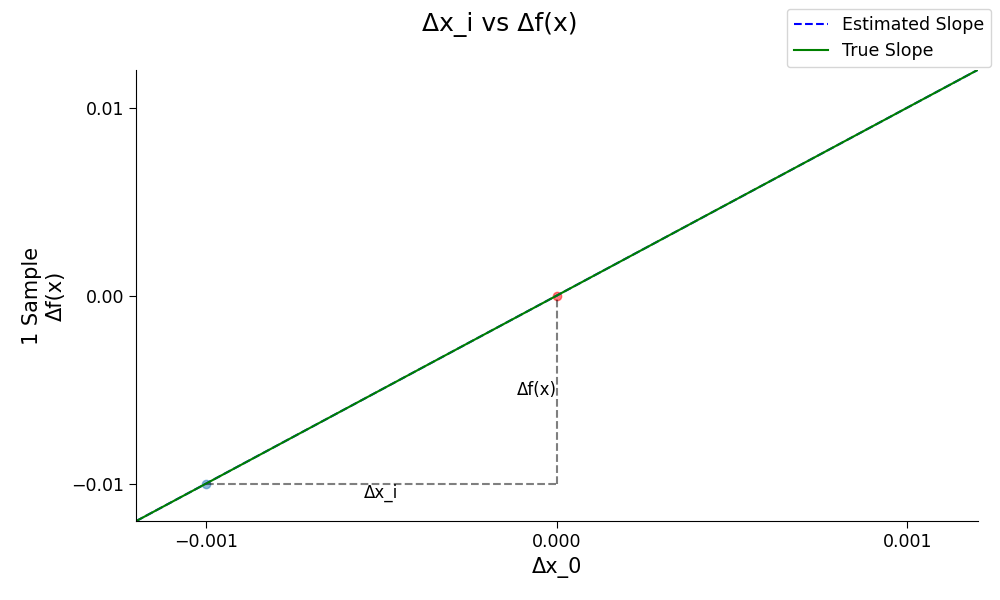

In [14]:
#@markdown **Run this cell** to see the picture

reg_rng = np.random.default_rng(42)
starting_distance_from_optimal = 5
N_Dim = 1
N_samples = [1]
perturbation_scale = 0.001

def simple_quadratic(x):
  return np.sum(x**2, axis=0)

def grad_simple_quadratic(x):
  return 2 * x

fig, axes = plt.subplots(len(N_samples), N_Dim, figsize=(10, 6), sharex='col', sharey='row', squeeze=False)
fig.suptitle('Δx_i vs Δf(x)')
remove_ip_clutter(fig)
x_init = reg_rng.standard_normal(size=N_Dim)  # size must cover the largest dimension
x_init = x_init / np.linalg.norm(x_init) * starting_distance_from_optimal
z_init = simple_quadratic(x_init)

raw_test_perturb = reg_rng.standard_normal(size=(N_Dim, max(N_samples)))
unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb, axis=1)[:, np.newaxis]
test_perturbation = unit_test_perturb * perturbation_scale
z_test = simple_quadratic(x_init[:, np.newaxis] + test_perturbation)
delta_z = z_test - z_init
for ii in range(N_Dim):
  for jj, N_sample in enumerate(N_samples):
    delta_x_i = test_perturbation[ii, :N_sample]
    delta_z_i = delta_z[:N_sample]
    ax = axes[jj, ii if N_Dim > 1 else 0]  # Adjust for single dimension
    ax.set_xlim(-0.0012, 0.0012)
    ax.set_ylim(-0.012, 0.012)
    ax.set_xticks([-0.001, 0, 0.001])
    ax.set_yticks([-0.01, 0, 0.01])
    scatter_plot = ax.scatter(delta_x_i, delta_z_i, alpha=0.5)
    origin_point = ax.scatter(0, 0, color='red', alpha=0.5)
    if N_sample == 1:
      hline_y = min(0, delta_z_i[0])
      hline_x_min = min(delta_x_i[0], 0)
      hline_x_max = max(delta_x_i[0], 0)
      vline_x = max(delta_x_i[0], 0)
      vline_y_min = min(delta_z_i[0], 0)
      vline_y_max = max(delta_z_i[0], 0)
      ax.hlines(hline_y, hline_x_min, hline_x_max, color='black', linestyle='--', alpha=0.5)
      ax.vlines(vline_x, vline_y_min, vline_y_max, color='black', linestyle='--', alpha=0.5)
      ax.text(hline_x_min + (hline_x_max - hline_x_min)/2, hline_y, 'Δx_i', fontsize=12, horizontalalignment='center', verticalalignment='top')
      ax.text(vline_x, vline_y_min + (vline_y_max - vline_y_min)/2, 'Δf(x)', fontsize=12, verticalalignment='center', horizontalalignment='right')
    # Compute slope for best fit line and plot
    slope = np.dot(delta_x_i, delta_z_i) / np.dot(delta_x_i, delta_x_i)
    x_vals = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
    best_fit_line, = ax.plot(x_vals, slope * x_vals, 'b--', label='Estimated Slope')
    # Compute and plot the theoretical line
    theoretical_slope = 2 * x_init[ii]  # For the first dimension perturbation
    theoretical_line, = ax.plot(x_vals, theoretical_slope * x_vals, 'g-', label='True Slope')
    if jj == len(N_samples)-1:
      ax.set_xlabel(f'Δx_{ii}')
    if ii == 0:
      sample_label = "Sample" if N_sample == 1 else "Samples"
      ax.set_ylabel(f'{N_sample} {sample_label}\nΔf(x)')
# Collect the legend from one subplot and apply outside the grid
handles, labels = ax.get_legend_handles_labels()
#print(handles)
#print(labels)
plt.subplots_adjust(hspace=0.1, wspace=0.1, right=0.85)  # Adjust right margin to make room for legend
fig.legend(handles, labels)
plt.show()

In one dimension the estimated slope and the true slope are perfectly aligned, but as we increase the number of dimensions, even just to three, things change.

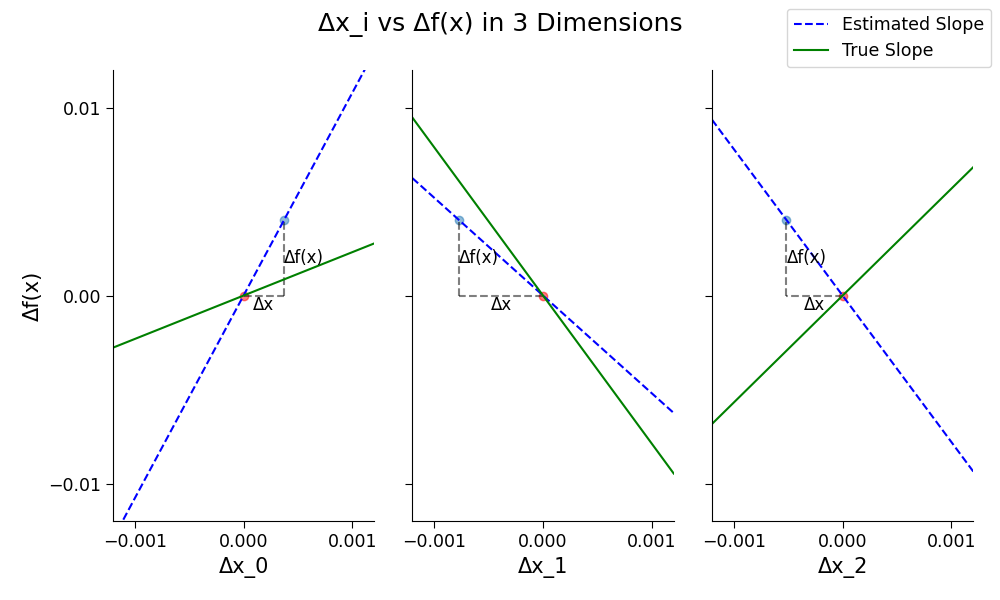

In [15]:
#@markdown **Run this cell** to see the picture

reg_rng = np.random.default_rng(42)
starting_distance_from_optimal = 5
N_Dim = 3
N_samples = [1]
perturbation_scale = 0.001

def simple_quadratic(x):
  return np.sum(x**2, axis=0)

def grad_simple_quadratic(x):
  return 2 * x

fig, axes = plt.subplots(len(N_samples), N_Dim, figsize=(10, 6), sharex='col', sharey='row', squeeze=False)
fig.suptitle('Δx_i vs Δf(x) in 3 Dimensions')
remove_ip_clutter(fig)
x_init = reg_rng.standard_normal(size=N_Dim)  # size must cover the largest dimension
x_init = x_init / np.linalg.norm(x_init) * starting_distance_from_optimal
z_init = simple_quadratic(x_init)

raw_test_perturb = reg_rng.standard_normal(size=(N_Dim, max(N_samples)))
unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb, axis=0, keepdims=True)
test_perturbation = unit_test_perturb * perturbation_scale
z_test = simple_quadratic(x_init[:, np.newaxis] + test_perturbation)
delta_z = z_test - z_init
for ii in range(N_Dim):
  for jj, N_sample in enumerate(N_samples):
    delta_x_i = test_perturbation[ii, :N_sample]
    delta_z_i = delta_z[:N_sample]
    ax = axes[jj, ii if N_Dim > 1 else 0]  # Adjust for single dimension
    ax.set_xlim(-0.0012, 0.0012)
    ax.set_ylim(-0.012, 0.012)
    ax.set_xticks([-0.001, 0, 0.001])
    ax.set_yticks([-0.01, 0, 0.01])
    scatter_plot = ax.scatter(delta_x_i, delta_z_i, alpha=0.5)
    origin_point = ax.scatter(0, 0, color='red', alpha=0.5)
    if N_sample == 1:
      x1, y1 = 0, 0  # Point A
      x2, y2 = delta_x_i[0], delta_z_i[0]  # Point B
      x3, y3 = x2, y1  # Point C
      ax.plot([x1, x3], [y1, y3], '--', color='black', alpha=0.5,)
      ax.plot([x3, x2], [y3, y2], '--', color='black', alpha=0.5,)
      # Adding labels to the legs
      ax.text((x1 + x3) / 2, y1, 'Δx', fontsize=12, ha='center', va='top')
      ax.text(x3, (y3 + y2) / 2, 'Δf(x)', fontsize=12, ha='left', va='center')
    # Compute slope for best fit line and plot
    slope = np.dot(delta_x_i, delta_z_i) / np.dot(delta_x_i, delta_x_i)
    x_vals = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
    best_fit_line, = ax.plot(x_vals, slope * x_vals, 'b--', label='Estimated Slope')
    # Compute and plot the theoretical line
    theoretical_slope = 2 * x_init[ii]  # For the first dimension perturbation
    theoretical_line, = ax.plot(x_vals, theoretical_slope * x_vals, 'g-', label='True Slope')
    if jj == len(N_samples)-1:
      ax.set_xlabel(f'Δx_{ii}')
    if ii == 0:
      if len(N_samples) > 1:
        sample_label = "Sample" if N_sample == 1 else "Samples"
        ax.set_ylabel(f'{N_sample} {sample_label}\nΔf(x)')
      else:
        ax.set_ylabel(f'Δf(x)')
# Collect the legend from one subplot and apply outside the grid
handles, labels = ax.get_legend_handles_labels()
#print(handles)
#print(labels)
plt.subplots_adjust(hspace=0.1, wspace=0.1, right=0.85)  # Adjust right margin to make room for legend
fig.legend(handles, labels)
plt.show()

For each seperate $\Delta x_i$ we are using the same $\Delta f(\mathbf{x})$, to estimate the slope, so instead of the perfect estimate of the slope that we had in the one dimensional case we have only a noisy estimated of the slope along any particular coordinate. The contributions to $\Delta f(\mathbf{x})$ from all the other coordinates are essentially a (very large) noise term that muddy the waters when we try to estimate the slope along any given coordinate direction. One way to overcome noise is to take the average of many samples. Run the cell below to see the same picture as above but with increasing numbers of samples used to estimate the slope line in each coordinate direction.

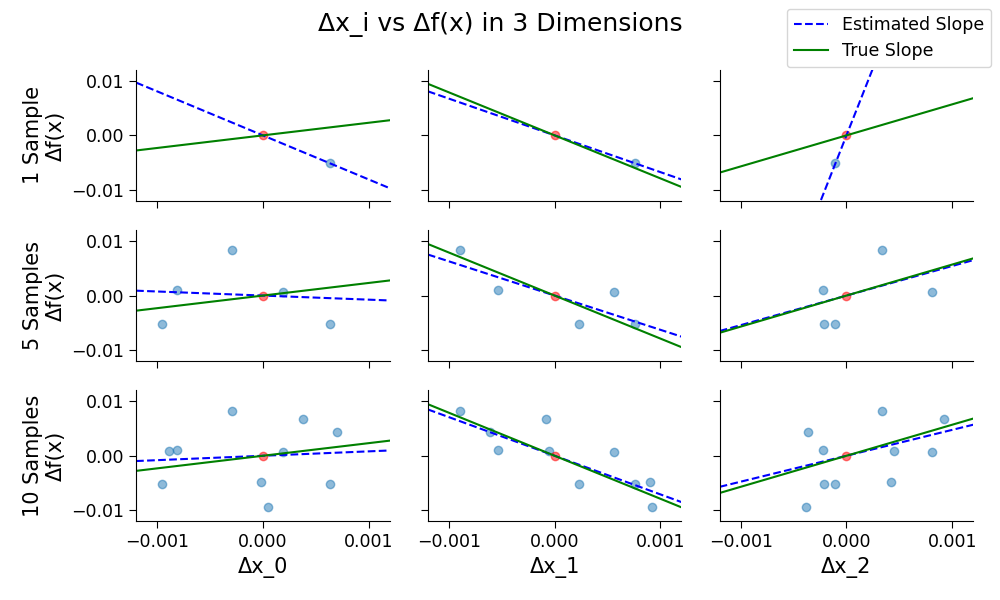

In [16]:
#@markdown **Run this cell** to see the picture

reg_rng = np.random.default_rng(42)
starting_distance_from_optimal = 5
N_Dim = 3
N_samples = [1, 5, 10]
perturbation_scale = 0.001

def simple_quadratic(x):
  return np.sum(x**2, axis=0)

def grad_simple_quadratic(x):
  return 2 * x

fig, axes = plt.subplots(len(N_samples), N_Dim, figsize=(10, 6), sharex='col', sharey='row', squeeze=False)
fig.suptitle('Δx_i vs Δf(x) in 3 Dimensions')
remove_ip_clutter(fig)
x_init = reg_rng.standard_normal(size=N_Dim)  # size must cover the largest dimension
x_init = x_init / np.linalg.norm(x_init) * starting_distance_from_optimal
z_init = simple_quadratic(x_init)

raw_test_perturb = reg_rng.standard_normal(size=(N_Dim, max(N_samples)))
unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb, axis=0, keepdims=True)
test_perturbation = unit_test_perturb * perturbation_scale
z_test = simple_quadratic(x_init[:, np.newaxis] + test_perturbation)
delta_z = z_test - z_init
for ii in range(N_Dim):
  for jj, N_sample in enumerate(N_samples):
    delta_x_i = test_perturbation[ii, :N_sample]
    delta_z_i = delta_z[:N_sample]
    ax = axes[jj, ii if N_Dim > 1 else 0]  # Adjust for single dimension
    ax.set_xlim(-0.0012, 0.0012)
    ax.set_ylim(-0.012, 0.012)
    ax.set_xticks([-0.001, 0, 0.001])
    ax.set_yticks([-0.01, 0, 0.01])
    scatter_plot = ax.scatter(delta_x_i, delta_z_i, alpha=0.5)
    origin_point = ax.scatter(0, 0, color='red', alpha=0.5)
    if N_sample == 1 and len(N_samples)==1:
      x1, y1 = 0, 0  # Point A
      x2, y2 = delta_x_i[0], delta_z_i[0]  # Point B
      x3, y3 = x2, y1  # Point C
      ax.plot([x1, x3], [y1, y3], '--', color='black', alpha=0.5,)
      ax.plot([x3, x2], [y3, y2], '--', color='black', alpha=0.5,)
      # Adding labels to the legs
      ax.text((x1 + x3) / 2, y1, 'Δx', fontsize=12, ha='center', va='top')
      ax.text(x3, (y3 + y2) / 2, 'Δf(x)', fontsize=12, ha='left', va='center')
    # Compute slope for best fit line and plot
    slope = np.dot(delta_x_i, delta_z_i) / np.dot(delta_x_i, delta_x_i)
    x_vals = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
    best_fit_line, = ax.plot(x_vals, slope * x_vals, 'b--', label='Estimated Slope')
    # Compute and plot the theoretical line
    theoretical_slope = 2 * x_init[ii]  # For the first dimension perturbation
    theoretical_line, = ax.plot(x_vals, theoretical_slope * x_vals, 'g-', label='True Slope')
    if jj == len(N_samples)-1:
      ax.set_xlabel(f'Δx_{ii}')
    if ii == 0:
      if len(N_samples) > 1:
        sample_label = "Sample" if N_sample == 1 else "Samples"
        ax.set_ylabel(f'{N_sample} {sample_label}\nΔf(x)')
      else:
        ax.set_ylabel(f'Δf(x)')
# Collect the legend from one subplot and apply outside the grid
handles, labels = ax.get_legend_handles_labels()
#print(handles)
#print(labels)
plt.subplots_adjust(hspace=0.1, wspace=0.1, right=0.85)  # Adjust right margin to make room for legend
fig.legend(handles, labels)
plt.show()

We can see that as the number of samples increase the estimated slope and the true slope more consistenty and closely align. How does this relate to our update rule? One of the key ideas of perturb-measure-step was to take steps that were proportional to the rate of improvement in the test direction. Note however, that this is not the same as taking a step in each coordinate direction proportional to the naive estimate of the slope in that direction. Such a naive update rule would look like this:

$$ \begin{align} \text{Naive (Bad) Update Rule:} \\
x_i' = x_i + s \ \frac{\Delta f(\mathbf{x})}{\Delta x_i} \end{align}$$

which is very different from our actual update rule

$$ \begin{align} \text{Actual (Good) Update Rule:} \\x_i' = x_i + s \ \Delta x_i \ \Delta f(\mathbf{x}) \end{align}$$

To see how these two different update rules relate to eachother we need to consider how the line of best fit is calculate in the plots above.

If we have say $k$ pairs of samples $(\Delta x_i^1, \Delta f(\mathbf{x}^1), (\Delta x_i^2, \Delta f(\mathbf{x}^2),\cdots, (\Delta x_i^k, \Delta f(\mathbf{x}^k)$, then the line of best fit (in simple linear regression) passing through $(\Delta x_i, \Delta f(\mathbf{x})) = (0,0)$ is determined by finding the value $\beta$ such that the sum of squared errors
$$ \sum_{j=1}^k \left(\beta \Delta x_i^j - \Delta f(\mathbf{x}^j)\right)^2$$
is minimized.

In this case we know that the mean of the distribution of sampled $\Delta x_i$ values is zero, as is the mean of the distribution of the sampled $\Delta f(\mathbf{x})$ values, and so (with some calculus and algebra) the minimizing value of $\beta$ is given by

$$\hat{\beta} = \frac{\sum_{j=1}^k \Delta x_i^j \Delta f(\mathbf{x}^j)}{\sum_{j=1}^k (\Delta x_i^j)^2}$$

So far not very informative, but some intuition can be gained by multiplying each term in each sum in the numerator by
$1 = \frac{\Delta x_i^j}{\Delta x_i^j}$.

$$\begin{align} \hat{\beta} &= \frac{\sum_{j=1}^k \Delta x_i^j \Delta f(\mathbf{x}^j)}{\sum_{j=1}^k (\Delta x_i^j)^2} \\
&= \frac{\sum_{j=1}^k \left(\Delta x_i^j\right)^2 \frac{\Delta f(\mathbf{x}^j)}{\Delta x_i^j}}{\sum_{j=1}^k (\Delta x_i^j)^2} \\
&= \sum_{j=1}^k \frac{\left(\Delta x_i^j\right)^2}{\sum_{l=1}^k \left(\Delta x_i^l\right)^2} \frac{\Delta f(\mathbf{x}^j)}{\Delta x_i^j}
\end{align}$$

From this we can see that the slope of the regression line is the weighted average of pointwise slopes, $\frac{\Delta f(\mathbf{x}^j)}{\Delta x_i^j}$, that is the slope of the line that connects the $j^{th}$ point to the mean, in our case $(0,0)$, of all points. These pointwise slope estimates are weighted by the square of the distance in the $i^{th}$ coordinate direction, that is $\left(\Delta x_i^j\right)^2$. Intuitively, the reason for this squared weighting that when minimizing the sum of squared errors, small changes in slope have a greater impact on the error from samples that are further out from the center point.

So from this point of veiw we can interpret our correct update rule
as the naive update rule, where the naive one-point slope estimate $\frac{\Delta f(\mathbf{x})}{\Delta x_i}$, is weighted by $\left(\Delta x_i\right)^2$, as is consistent with a linear-regression style estimate of the gradient, that is:

$$ \begin{align}
x_i' &= x_i + s \ \left(\Delta x_i\right)^2 \ \frac{\Delta f(\mathbf{x})}{\Delta x_i} \\
&= x_i + s \ \Delta x_i \ \Delta f(\mathbf{x})\end{align}$$

The point of all this is that the perturb-measure-step algorithm can be thought of as a ***noisy*** application of the gradient, and as such it will not always shift to a better value for a given $x_i$, it may sometimes shift to worse $x_i$ value. This ***noise*** arises from the fact that we are trying to use a single global reward signal $\Delta f(\mathbf{x})$ to inform updates for the $n$ distinct components $\mathbf{x}$ without leveraging any a-priori knowledge of how the different components of $\mathbf{x}$ causally impact $f(x)$. That is we use no knowledge of the structure of $f$ in guiding our updates of $\mathbf{x}$. This is much like evolution which simply selects those individuals with the phenotypes well suited to the current environment, without any knowledge or awareness of how the various alleles of the selected individual causally relate to their phenotypes and resulting fitness. However, much like evolution, perturb-measure-step does on ***average*** shift each $x_i$ to a better value, so that over many interations, eventually, every component of $\mathbf{x}$ will converge on a (at least locally and relatively) good value. Optimization processes, like evolution, and peturb-measure-step that operate without using any knowledge of a function's underlying structure are called zero-orde(such methods only require function evaluation, not evaluation of the first or second derivatives of the function, hence zero order). Perturb-measure-step is of particular interest to us because although it is a zero-order method, it can be interpreted as estimating the gradient and hence as a kind of bridge to first-order methods like gradient descent that do take advantage of knowledge of the structure of a function by computing and utilizing the gradient (first-derivative) of the function to inform optimization.



We should note that some problems may only be 'superfically' high dimensional, e.g.
$$\min_{\mathbf{x} \in \mathcal{R}^n} f(\mathbf{x}) = \left(x_0\right)^2$$ Although there are ostensibly $n$ dimensions to consider here, only one component of $\mathbf{x}$ has any causal impact on the function evaluation, and so with an appropriate step-scaling factor, stochastic-perturb-measure-step will be about as fast in this superfically high dimensional problem as it is in on a 1-dimensional problem.

Now that we have a sense of how and why propose-accept-reject and perturb-measure-step slow down on high dimensional optimization problems, we are going to shift our focus to the simplest kinds of problems the brain is solving. We will find that even solving even these very simple seeming problems effecitvely can require high-dimensional optimization. We will also find that there are alternatives to and enhancements of these learning algorithms that allow for more rapid learning in such high dimensional problems.

In [17]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M5")